In [1]:
#An examples of a sparse fully connected denoising auto-encoder using 
#x-entopy in the cost function

In [2]:
from sAE1 import AE

In [3]:
#Some dirs
import os
inDataDir=os.getcwd()

In [4]:
#Get the data:
import theano
theano.config.floatX='float32'
import cPickle as pickle
import numpy as np

f=open(inDataDir+'/mnist.pkl')
train, test, valid=pickle.load(f)
trainData=train[0]
np.random.shuffle(trainData) #Shuffel the image order
print 'Training Data Shape:',np.shape(trainData)

Training Data Shape: (50000, 784)


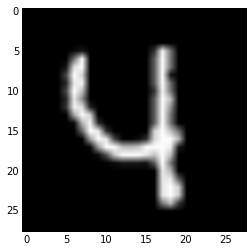

In [5]:
#Check a few samples
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(trainData[3,:].reshape(28,28), cmap='gray')

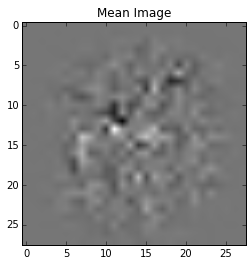

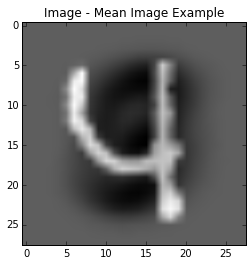

In [6]:
#Take away the mean and divide by STD then re-scale to be 0-1
trainData-=np.mean(trainData, axis=0)
plt.figure()
plt.imshow((np.mean(trainData, axis=0).reshape(28,28)), cmap='gray')
plt.title('Mean Image')
trainData-=255
trainData/=255

trainData/=trainData.std()

trainData-=trainData.min()
trainData/=trainData.max()

from matplotlib import pyplot as plt
plt.figure()
plt.imshow(trainData[3,:].reshape(28,28), cmap='gray')
plt.title('Image - Mean Image Example')

In [7]:
#Make the data a shared variable
train_set=theano.shared(value=np.asarray(trainData, dtype=theano.config.floatX),borrow=True)
print train_set.dtype

float32


In [8]:
from theano.tensor.shared_randomstreams import RandomStreams
from theano import tensor as T 
#from PIL import Image
import numpy as np
import cPickle as pickle
#from data_loader import load_data
import os
import theano
theano.config.floatX='float32'

In [9]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [25]:
#Symbolic vars
index = T.lscalar()    # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images

#Create a new AE
rand=np.random.randint(low=0, high=10**10,size=1)
rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2**30))

#vars:
n_hidden=900
noiseLevel=0.3  #Noise added to the image
learnRate=0.01 
roh=0.05  #The desired sparsity
beta=0.5  #The weight of the sparsity in the cost function
max_epoch=50
batchSize=100

#Compute no of mini-batches:
n_batches=train_set.get_value(borrow=True).shape[0]/batchSize

newAE=AE(
	numpy_rndgen=rng,
	theano_rndgen= theano_rng,
	input=x,
	n_in=28*28,
	n_hidden=n_hidden,
	)

cost, updates, roh_hat, error = newAE.getUpdate(
	noiseLevel=noiseLevel,
	learnRate=learnRate,
	roh=roh,
	beta=beta,
	)

trainAE = theano.function(
	inputs=[index],
	outputs=[cost, roh_hat,error],
	updates=updates,
	givens={
		x: train_set[index*batchSize:(index+1)*batchSize]  #N.B. has shape (batch_size x 784)
		}
	)

minCost='Inf'
epoch_cost=[] #Stores the cost on each epoch (use for plotting)
epoch_roh_hat=[]
print 'Epoch \t Cost \t Roh_hat'
for epoch in xrange(max_epoch):
    c=[]
    r=[]
    for batch_idx in xrange(n_batches):
        cost, roh_hat,error=trainAE(batch_idx)
        c.append(cost)
        r.append(roh_hat)
    epoch_cost.append(np.mean(c))
    epoch_roh_hat.append(np.mean(roh_hat))
    if(np.mean(c)<minCost):
        minCost=np.mean(c)
        print epoch+1, '\t',  bcolors.OKGREEN , np.mean(c) , bcolors.ENDC, '\t', np.mean(roh_hat)
    else:
        print epoch+1, '\t', np.mean(c), '\t', np.mean(roh_hat)

        

Wenc: float32
Wdec: float32
benc: float32
bdec: float32
Wenc: [784 900] Wdec: [900 784]
benc: [900] bdec: [784]
input: float32
encoding...
decoding...
float32
Epoch 	 Cost 	 Roh_hat
1 	 517.007  	0.0571495
2 	 508.347  	0.0526658
3 	 508.066  	0.0501636
4 	 507.854  	0.0507587
5 	 507.646  	0.0503691
6 	 507.426  	0.0504154
7 	 507.204  	0.0506717
8 	 506.965  	0.0511939
9 	 506.71  	0.0505981
10 	 506.422  	0.0516896
11 	 506.082  	0.0514365
12 	 505.654  	0.0524186
13 	 505.095  	0.0528602
14 	 504.35  	0.0539977
15 	 503.379  	0.055332
16 	 502.313  	0.0561628
17 	 501.286  	0.0559027
18 	 500.188  	0.0567252
19 	 498.95  	0.0579211
20 	 497.628  	0.05765
21 	 496.328  	0.0568218
22 	 495.136  	0.0573772
23 	 494.083  	0.0583719
24 	 493.145  	0.0575847
25 	 492.319  	0.0577829
26 	 491.583  	0.0578747
27 	 490.898  	0.0573884
28 	 490.264  	0.0567644
29 	 489.662  	0.0574367
30 	 489.095  	0.057754
31 	 488.541  	0.057832
32 	 488.024  	0.0577557
33 	 487.542  	0.0582499
34 	 487.1

/Users/AntoinaCreswell/Documents/PhD_Yr1/OpenSourceCode/DeepLearningRepo/sAE/venv/lib/python2.7/site-packages/ipykernel/__main__.py:59: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error


In [26]:
#Save the model:
pickle.dump(newAE,open('model.pkl','w'))

#Test the load
trainedAE=pickle.load(open('model.pkl'))

W=trainedAE.Wenc.get_value()
print 'Trained Wenc:', np.shape(W)


weightCols=np.zeros((1,281))
n=0
for i in range(10):
	weightRows=np.zeros((28,1))
	for j in range(10):
		weight=W[:,n].reshape(28,28)
		n+=1
		weightRows=np.hstack((weightRows,weight))
	weightCols=np.vstack((weightCols,weightRows))

Trained Wenc: (784, 900)


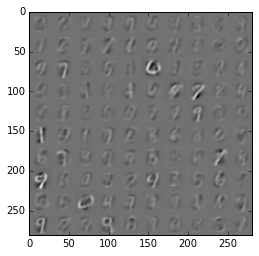

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(weightCols, cmap='gray')

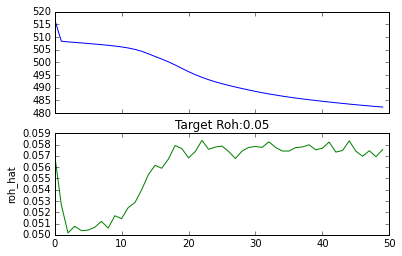

In [30]:
#Plot cost
[f,ax]=plt.subplots(2, sharex=True)
plt.title('cost per epoch')
plt.ylabel('cost')
ax[0].plot(range(max_epoch),epoch_cost,'b')
plt.title('Target Roh:'+str(roh))
plt.ylabel('roh_hat')
ax[1].plot(range(max_epoch),epoch_roh_hat,'g')

encoding...
decoding...
encoding...
decoding...
encoding...
decoding...


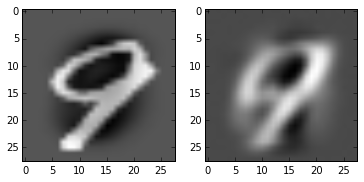

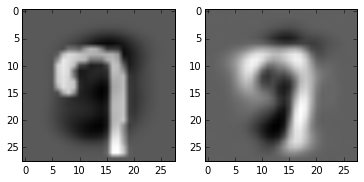

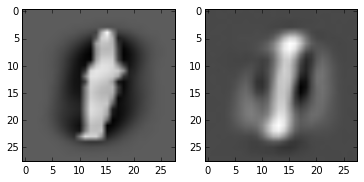

In [33]:
#Test a reconstruction
for i in range(500,2000,500):  #Just reconstruct 3
    imSample=train_set[i,:]
    encoded=newAE.encode(imSample)
    decoded=newAE.decode(encoded)
    f,ax=plt.subplots(1,2)
    ax[0].imshow(imSample.eval().reshape(28,28),cmap='gray')
    ax[1].imshow(decoded.eval().reshape(28,28),cmap='gray')
